<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/WalkingSittingStanding_KDE_visualising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

Cloning into 'LatentCfMultivariate'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 284 (delta 125), reused 152 (delta 105), pack-reused 105
Receiving objects: 100% (284/284), 13.24 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [2]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 10.0 MB/s eta 0:00:00


In [3]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

In [5]:
RANDOM_STATE = 39
X, y = load_classification('WalkingSittingStanding')
X = X.transpose(0,2,1)

#print(f'data imformation = {data_information}')
#keep half the dataset because it is too big
X,X_through,y,y_through = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (5149, 206, 3)
shape of y = (5149,)
shape of X train = (4119, 206, 3)
shape of y train = (4119,)


In [6]:
#Upsample the minority class

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
X,y = upsample_minority_multivariate(X, y)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [689 618 562 710 762 778]
after: [778 778 778 778 778 778]


In [7]:
#Processing and Padding all our data
#Padding needed for autoencoder

n_training,n_timesteps, n_features= X_train.shape

X, trained_scaler =  normalize_multivariate(data=X, n_timesteps=n_timesteps, n_features = n_features)
X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X, padding_size = conditional_pad_multivariate(X)
X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=206, padded #timesteps=208.

min value = -1.639609, max value = 2.157473
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (4668, 206, 3)
X_train_processed_padded.shape = (4668, 208, 3)


In [8]:

def extract_two_classes(X,y,n_1,n_2, RANDOM_STATE):
  #get the normal and abnormal label
  #abnormal is the target label for the latentCF++ model
  normal_label = n_1
  abnormal_label = n_2

  #Get the indices
  normal_indices = np.where(y == normal_label)[0]
  abnormal_indices = np.where(y == abnormal_label)[0]

  #Use the indices to get the wanted data points
  X_abnormal = X[abnormal_indices]
  y_abnormal = y[abnormal_indices]

  X_normal = X[normal_indices]
  y_normal = y[normal_indices]

  #stack all the data together again
  X = np.concatenate([X_abnormal,X_normal])
  y = np.concatenate([y_abnormal,y_normal])

  #shuffle them
  X, y = shuffle(X, y, random_state=RANDOM_STATE)

  #iterate over the dataset to make the labels 0 for abnormal and 1 for normal

  for i in range(y.shape[0]):
    if y[i] == n_2:
      y[i]=1
    else:
      y [i]=0

  y = y.astype(int)
  print(f'Class 0 represents number {n_1}. [1.,0.]')
  print(f'Class 1 represents number {n_2}. [0.,1.]\n')

  return X,y

In [9]:
y

array(['0.0', '0.0', '0.0', ..., '5.0', '5.0', '5.0'], dtype='<U3')

In [10]:
X, y = extract_two_classes(X,y,'0.0','5.0', RANDOM_STATE)
X_train, y_train = extract_two_classes(X_train_processed_padded,y_train,'0.0','5.0', RANDOM_STATE)
X_test, y_test = extract_two_classes(X_test_processed_padded,y_test,'0.0','5.0', RANDOM_STATE)

Class 0 represents number 0.0. [1.,0.]
Class 1 represents number 5.0. [0.,1.]

Class 0 represents number 0.0. [1.,0.]
Class 1 represents number 5.0. [0.,1.]

Class 0 represents number 0.0. [1.,0.]
Class 1 represents number 5.0. [0.,1.]



In [11]:
#splitting the dataset

from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

In [12]:
#Getting the two forms of labels needed
#-the y_classes (1,0,1,0,...)
#-the y (one hot encoded)

print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_classes = y
y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y = to_categorical(y, len(np.unique(y)))
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1244, 208, 3)
X_validation = (312, 208, 3)
X_test = (366, 208, 3)

y_train_classes = (1244,), y_validation_classes = (312,), y_test_classes = (366,)
y_train = (1244, 2), y_validation = (312, 2), y_test= (366, 2)


In [26]:
y_classes[4]

0

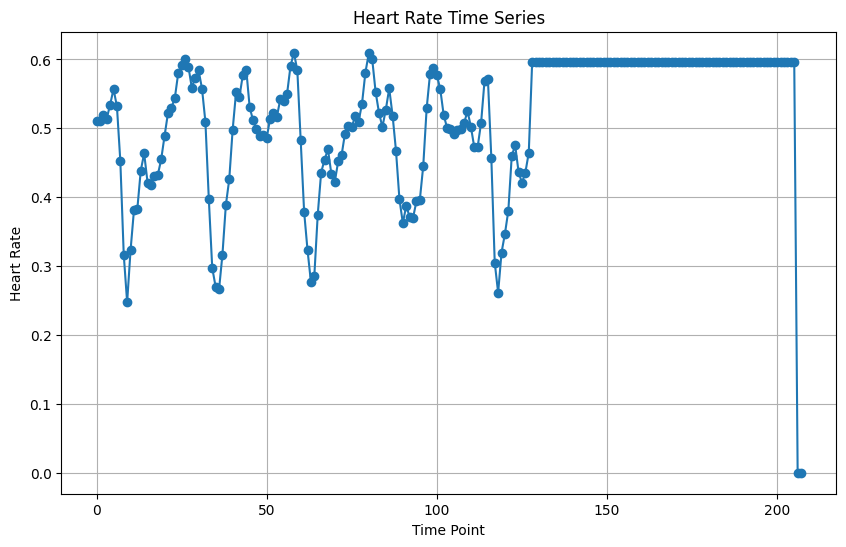

In [24]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(len(X[1,:,1])), X[4,:,1], marker='o', linestyle='-')
plt.title('Heart Rate Time Series')
plt.xlabel('Time Point')
plt.ylabel('Heart Rate')
plt.grid(True)
plt.show()

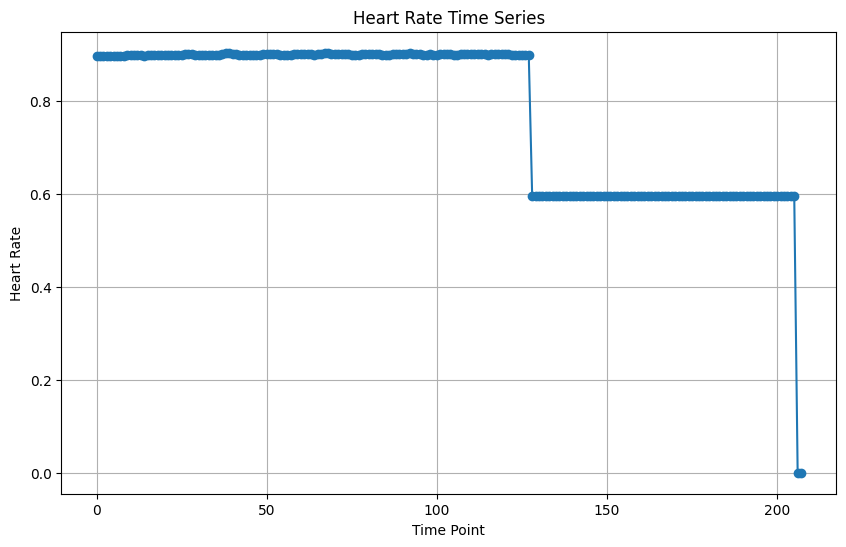

In [21]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(len(X[1,:,1])), X[1,:,1], marker='o', linestyle='-')
plt.title('Heart Rate Time Series')
plt.xlabel('Time Point')
plt.ylabel('Heart Rate')
plt.grid(True)
plt.show()

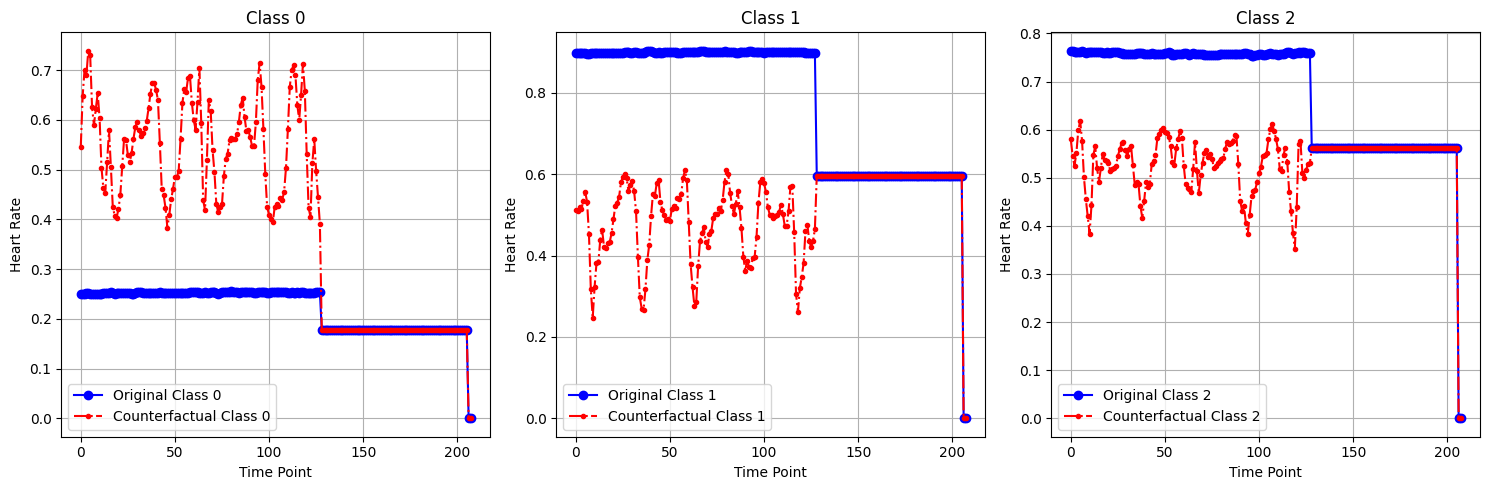

In [34]:
import matplotlib.pyplot as plt

# Example data for two classes for each dimension
heart_rate_data_class1 = X[1,:,1]
heart_rate_data_class2 = [65, 70, 72, 75, 78, 80, 82, 85, 87, 88, 90, 92]
temperature_data_class1 = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
temperature_data_class2 = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pressure_data_class1 = [1010, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020]
pressure_data_class2 = [1009, 1011, 1012, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plotting each dimension for class 1
axs[0].plot(range(len(X[1,:,1])), X[1,:,0], marker='o', linestyle='-', color='blue', label='Original Class 0')
axs[0].set_title('Class 0')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Heart Rate')
axs[0].grid(True)

axs[1].plot(range(len( X[1,:,1])), X[1,:,1], marker='o', linestyle='-', color='blue', label='Original Class 1')
axs[1].set_title('Class 1')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Heart Rate')
axs[1].grid(True)

axs[2].plot(range(len( X[1,:,1])), X[1,:,2], marker='o', linestyle='-', color='blue', label='Original Class 2')
axs[2].set_title('Class 2')
axs[2].set_xlabel('Time Point')
axs[2].set_ylabel('Heart Rate')
axs[2].grid(True)

# Plotting each dimension for class 2
axs[0].plot(range(len( X[1,:,1])), X[4,:,0], marker='.', linestyle='-.', color='red', label='Counterfactual Class 0')
axs[1].plot(range(len( X[1,:,1])), X[4,:,1], marker='.', linestyle='-.', color='red', label='Counterfactual Class 1')
axs[2].plot(range(len( X[1,:,1])), X[4,:,2], marker='.', linestyle='-.', color='red', label='Counterfactual Class 2')

# Add legends
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(X[1,:,1], values, marker='o', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()


NameError: name 'values' is not defined

<Figure size 1000x600 with 0 Axes>

In [36]:
def Classifier(
    n_timesteps, n_features, n_conv_layers=1, add_dense_layer=True, n_output=2
):
    # https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

    input_shape = ( n_timesteps,n_features)

    inputs = keras.Input(shape=input_shape, dtype="float32")

    if add_dense_layer:
        x = keras.layers.Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(inputs)
    else:
        x = inputs

    for i in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier

In [37]:
X_train.shape


(1244, 208, 3)

In [38]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [39]:


# ## LatentCF++ models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### 1dCNN classifier

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=2, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:1", "True:0"],
    columns=["Pred:1", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
104/104 [==============================] - 6s 7ms/step - loss: 0.0476 - accuracy: 0.9960 - val_loss: 0.2940 - val_accuracy: 1.0000
Epoch 2/150
104/104 [==============================] - 1s 5ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.1461 - val_accuracy: 1.0000
Epoch 3/150
104/104 [==============================] - 0s 5ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 1.0000
Epoch 4/150
104/104 [==============================] - 1s 5ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 5/150
104/104 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 6/150
104/104 [==============================] - 1s 5ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/150
104/104 [==============================] - 1s 5ms/step - loss: 0.0034 - accuracy: 1.0000 - v

In [40]:
reset_seeds()

# ### 1dCNN autoencoder
autoencoder = Autoencoder( n_timesteps_padded,n_features,32)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


(None, 208, 3)
(None, 208, 32)
(None, 104, 32)
(None, 104, 16)
(None, 52, 16)
(None, 52, 16)
(None, 104, 16)
(None, 104, 32)
(None, 208, 32)
(None, 208, 3)
Training log for 1dCNN autoencoder:
Epoch 1/50
104/104 - 4s - loss: 0.0589 - val_loss: 0.0048 - 4s/epoch - 37ms/step
Epoch 2/50
104/104 - 1s - loss: 0.0028 - val_loss: 0.0016 - 673ms/epoch - 6ms/step
Epoch 3/50
104/104 - 1s - loss: 0.0013 - val_loss: 0.0011 - 684ms/epoch - 7ms/step
Epoch 4/50
104/104 - 1s - loss: 0.0010 - val_loss: 9.1851e-04 - 677ms/epoch - 7ms/step
Epoch 5/50
104/104 - 1s - loss: 8.6876e-04 - val_loss: 7.7357e-04 - 652ms/epoch - 6ms/step
Epoch 6/50
104/104 - 1s - loss: 7.4103e-04 - val_loss: 6.8314e-04 - 660ms/epoch - 6ms/step
Epoch 7/50
104/104 - 1s - loss: 6.6143e-04 - val_loss: 6.2862e-04 - 688ms/epoch - 7ms/step
Epoch 8/50
104/104 - 1s - loss: 6.1598e-04 - val_loss: 5.8219e-04 - 641ms/epoch - 6ms/step
Epoch 9/50
104/104 - 1s - loss: 5.8368e-04 - val_loss: 5.6007e-04 - 640ms/epoch - 6ms/step
Epoch 10/50
104/104

In [41]:
#Gettting the Global weights, needed for counterfactuals

from _guided import get_global_weights
from help_functions import evaluate
pos_label = 1
neg_label = 0

step_weights = get_global_weights(
        X,
        y_classes,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
)


61/61 [==============================] - 0s 2ms/step


In [42]:
step_weights

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1

In [43]:
# @title Default title text
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
#from LIMESegment.Utils.explanations import LIMESegment


class ModifiedLatentCF:
    """Explanations by generating a counterfacutal sample in the latent space of
    any autoencoder.

    References
    ----------
    Learning Time Series Counterfactuals via Latent Space Representations,
    Wang, Z., Samsten, I., Mochaourab, R., Papapetrou, P., 2021.
    in: International Conference on Discovery Science, pp. 369–384. https://doi.org/10.1007/978-3-030-88942-5_29
    """

    def __init__(
        self,
        probability=0.5,
        *,
        tolerance=1e-6,
        max_iter=100,
        optimizer=None,
        autoencoder=None,
        margin_weight=1.0,  # weighted_steps_weight = 1 - pred_margin_weight
        random_state=None,
        bandwidth,
        weighted_steps_weight,
        data,
        step_weights
    ):
        self.optimizer_ = (
            tf.optimizers.Adam(learning_rate=1e-4) if optimizer is None else optimizer
        )
        #self.x_axis_eights = x_axis_eights
        #self.y_axis_eights = y_axis_eights
        self.data = data
        self.mse_loss_ = keras.losses.MeanSquaredError()
        self.probability_ = tf.constant([probability])
        self.tolerance_ = tf.constant(tolerance)
        self.max_iter = max_iter
        self.autoencoder = autoencoder
        self.random_state = random_state
        self.weighted_steps_weight = weighted_steps_weight
        self.step_weights = step_weights

        # Weights of the different loss components
        self.margin_weight = margin_weight
        self.kde_weight = tf.cast(1 - self.margin_weight-self.weighted_steps_weight,tf.float32)
        if (self.weighted_steps_weight+self.margin_weight)>1.0:
           raise ValueError("(weighted_steps_weight + margin_weight) should be less that 1.0")

        self.bandwidth = bandwidth

    def fit(self, model):
        """Fit a new counterfactual explainer to the model

        Paramaters
        ----------

        model : keras.Model
            The model
        """
        if self.autoencoder:
            (
                encode_input,
                encode_output,
                decode_input,
                decode_output,
            ) = extract_encoder_decoder(self.autoencoder)
            self.decoder_ = keras.Model(inputs=decode_input, outputs=decode_output)
            self.encoder_ = keras.Model(inputs=encode_input, outputs=encode_output)
        else:
            self.decoder_ = None
            self.encoder_ = None
        self.model_ = model
        return self

    def predict(self, x):
        """Compute the difference between the desired and actual probability

        Parameters
        ---------
        x : Variable
            Variable of the sample
        """
        if self.autoencoder is None:
            z = x
        else:
            z = self.decoder_(x)

        return self.model_(z)

    # The "pred_margin_loss" is designed to measure the prediction probability to the desired decision boundary
    def pred_margin_mse(self, prediction):
        return self.mse_loss_(self.probability_, prediction)

    # An auxiliary MAE loss function to measure the proximity with step_weights
    def weighted_mae(self, original_sample, cf_sample, step_weights):
        return tf.math.reduce_mean(
            tf.math.multiply(tf.math.abs(original_sample - cf_sample), step_weights)
        )

    # An auxiliary normalized L2 loss function to measure the proximity with step_weights
    def weighted_normalized_l2(self, original_sample, cf_sample, step_weights):
        var_diff = tf.math.reduce_variance(original_sample - cf_sample)
        var_orig = tf.math.reduce_variance(original_sample)
        var_cf = tf.math.reduce_variance(cf_sample)

        normalized_l2 = 0.5 * var_diff / (var_orig + var_cf)
        return tf.math.reduce_mean(
            tf.math.multiply(
                normalized_l2,
                step_weights,
            )
        )
    #x_axis_eights*self.step_weights_x,use_scotts_rule=False,use_silvermans_rule=True,manual_bandwidth = 0.1
    def train_gaussian_kde(self, data, use_scotts_rule,use_silvermans_rule, manual_bandwidth ):
      """
      Train a Gaussian KDE on the provided data.

      :param data: Multivariate data points used for KDE (2D Tensor).
      :param bandwidth: The bandwidth of the kernel (float).
      :return: A function that represents the trained KDE.
      """

      n = tf.cast(tf.shape(data)[0], tf.float32)
      d = tf.cast(tf.shape(data)[1], tf.float32)
      def kde_fn( x_points):
        """
        Compute the density estimation for given points using the trained KDE.

        :param x_points: Points where the density should be estimated (2D Tensor).
        :return: Density estimates (Tensor).
        """
        d = tf.cast(tf.shape(data)[1], tf.float32)

        data_exp =  tf.expand_dims(data, axis=0)
        #print(f'x_points shape = {x_points.shape} in kde fn')
        x_points_exp = tf.reshape(x_points, (tf.shape(x_points)[0], 208, 1))

        x_points_exp = tf.expand_dims(x_points_exp, axis=1)
        if use_scotts_rule:
          sigma = tf.math.reduce_std(data)
          sigma = tf.cast(sigma,tf.float32)
          bandwidth = n ** (-1.0 / (d + 4)) * sigma
        elif use_silvermans_rule:
          sigma = tf.math.reduce_std(data)
          bandwidth = (4 * sigma**5 / (3 * n)) ** (1/5)
        else:
          if manual_bandwidth is None:
            raise ValueError("Manual bandwidth must be provided if not using Scott's Rule.")
          bandwidth = manual_bandwidth

        bandwidth = tf.cast(bandwidth, tf.float32)
        x_points_exp = tf.cast(x_points_exp,tf.float32)
        data_exp= tf.cast(data_exp, tf.float32)
        diff = x_points_exp - data_exp
        norm = tf.reduce_sum(diff ** 2, axis=2)
        kernel_val = tf.exp(-norm / (2.0 * bandwidth ** 2))


        d = tf.constant(d,tf.float32)
        density = tf.reduce_mean(kernel_val, axis=1) / (bandwidth * tf.sqrt(2.0 * np.pi * d))
        return density

      return kde_fn

    def gaussian_kde_logpdf(self, kde_fn, x_points):
      """
      Evaluate the logpdf of the given points using the trained KDE function.

      :param kde_fn: Trained KDE function.
      :param x_points: Points to evaluate the logpdf (2D Tensor).
      :return: Log of the density estimates (Tensor).
      """
      #print(f'x_points shape = {x_points.shape} in gaussian kde')
      density = kde_fn(x_points)
      return tf.math.log(density)


    # additional input of step_weights
    def compute_loss(self,original_sample, z_search, target_label, kde_stop):
        loss = tf.zeros(shape=())
        decoded = self.decoder_(z_search) if self.autoencoder is not None else z_search
        pred = self.model_(decoded)[:, target_label]

        #margin loss (y-τ)
        margin_loss = self.pred_margin_mse(pred)
        loss += self.margin_weight * margin_loss

        kde_diffrences = []
        for dimention in range(decoded.shape[2]):
          data_dimention = self.data[:,:,dimention]
          data_dimention = data_dimention[:,:,np.newaxis]
          kde = self.train_gaussian_kde(data = data_dimention,use_scotts_rule=False,use_silvermans_rule=False,manual_bandwidth = self.bandwidth)
          #print(f'data_dimention shape = {data_dimention.shape} in compute loss just before computting mean log likellihood for all the data ')
          mean_log_likelihood = tf.cast(tf.reduce_mean(self.gaussian_kde_logpdf(kde, x_points = (data_dimention))),tf.float32)

          decoded_dimention = decoded[:,:,dimention]
          decoded_dimention = decoded_dimention[:,:,np.newaxis]
          #print(f'decoded_dimention shape = {decoded_dimention.shape} in compute loss just before computting mean log likellihood for decoded data ')
          log_likelihood_of_sample = tf.cast(self.gaussian_kde_logpdf(kde, x_points = (decoded_dimention)),tf.float32)

          kde_loss = tf.cast((mean_log_likelihood - log_likelihood_of_sample),tf.float32)
          kde_diffrences.append(kde_loss)
        kde_total_loss = tf.math.add_n(kde_diffrences)
        kde_total_loss = tf.math.abs(kde_total_loss)
        #print(kde_total_loss)
        loss +=self.kde_weight *kde_total_loss


        weighted_steps_loss = self.weighted_mae(
            original_sample=tf.cast(original_sample, dtype=tf.float32),
            cf_sample=tf.cast(decoded, dtype=tf.float32),
            step_weights=tf.cast(step_weights, tf.float32),
        )
        loss += self.weighted_steps_weight * weighted_steps_loss

        return loss, margin_loss, kde_loss, kde_stop

    # TODO: compatible with the counterfactuals of wildboar
    #       i.e., define the desired output target per label


    def transform(self, x, pred_labels):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """

        result_samples = np.empty(x.shape)
        losses = np.empty(x.shape[0])
        # `weights_all` needed for debugging
        weights_all = np.empty((x.shape[0], 1, x.shape[1], x.shape[2]))
        for i in range(x.shape[0]):
            if i % 25 == 0:
                print(f"{i+1} samples been transformed.")
            kde_stop = False

            x_sample, loss = self._transform_sample(
                x[np.newaxis, i], pred_labels[i],kde_stop
            )

            result_samples[i] = x_sample
            losses[i] = loss
            weights_all[i] = step_weights

        print(f"{i+1} samples been transformed, in total.")

        return result_samples, losses, weights_all

    def _transform_sample(self, x, pred_label,kde_stop):
        """Generate counterfactual explanations(z))"""
        # TODO: check_is_fitted(self)
        if self.autoencoder is not None:
            z = tf.Variable(self.encoder_(x))
        else:
            z = tf.Variable(x, dtype=tf.float32)

        it = 0
        target_label = 1 - pred_label  # for binary classification

        #def compute_loss(self,original_sample, z_search, target_label)
        with tf.GradientTape(persistent = True) as tape:
            loss, pred_margin_loss, kde_loss, kde_stop = self.compute_loss(
                x, z,  target_label,kde_stop
            )
        if self.autoencoder is not None:
            pred = self.model_(self.decoder_(z))
        else:
            pred = self.model_(z)


        while (
            (loss > self.tolerance_
            and pred[:, target_label] < self.probability_)
            and (it < self.max_iter if self.max_iter else True)
            ) :
            # Get gradients of loss wrt the sample
            grads = tape.gradient(loss, z)
            # Update the weights of the sample
            self.optimizer_.apply_gradients([(grads, z)])
            del tape

            #self,original_sample, z_search, target_label
            with tf.GradientTape(persistent=True) as tape:
                loss, pred_margin_loss, kde_loss, kde_stop = self.compute_loss(
                    x, z,  target_label,kde_stop
                )

            kde_loss = tf.convert_to_tensor(kde_loss, dtype=tf.float32)
            grads = tape.gradient(loss, z)
            # Optionally, compute and log gradients for individual components
            kde_grads = tape.gradient(kde_loss, z)
            margin_grads = tape.gradient(pred_margin_loss, z)


            it += 1
            #if it % 50 == 0:
              #print(f'Currently on iteration: {it}.')
            #   # print(f'kde loss : {kde_loss}')
            #   # print(f'margin loss : {pred_margin_loss}')
            #   # print(f'loss : {loss}')

            #   if kde_grads is  None:
            #     print("KDE Gradients are None.")
            if self.autoencoder is not None:
                pred = self.model_(self.decoder_(z))
            else:
                pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}. \n"
        # )

        res = z.numpy() if self.autoencoder is None else self.decoder_(z).numpy()
        return res, float(loss)




In [47]:
 reset_seeds()

cf_model = ModifiedLatentCF(
    probability=0.9,
    tolerance=1e-6,
    max_iter=500,
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    autoencoder = autoencoder,
    margin_weight=0.7,
    random_state= RANDOM_STATE,
    bandwidth = 0.9,
    weighted_steps_weight = 0.2,
    data = X_train[y_train_classes == 1],
    step_weights = step_weights
    )
cf_model.fit(cnnClassifier)


y_neg = y_classes[y_classes == 0][:10]
X_neg = X[y_classes == 0][:10]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    cf_embeddings, losses, weights = cf_model.transform(x = X_neg,pred_labels = y_neg)


1 samples been transformed.
10 samples been transformed, in total.


In [49]:
cf_embeddings.shape

(10, 208, 3)

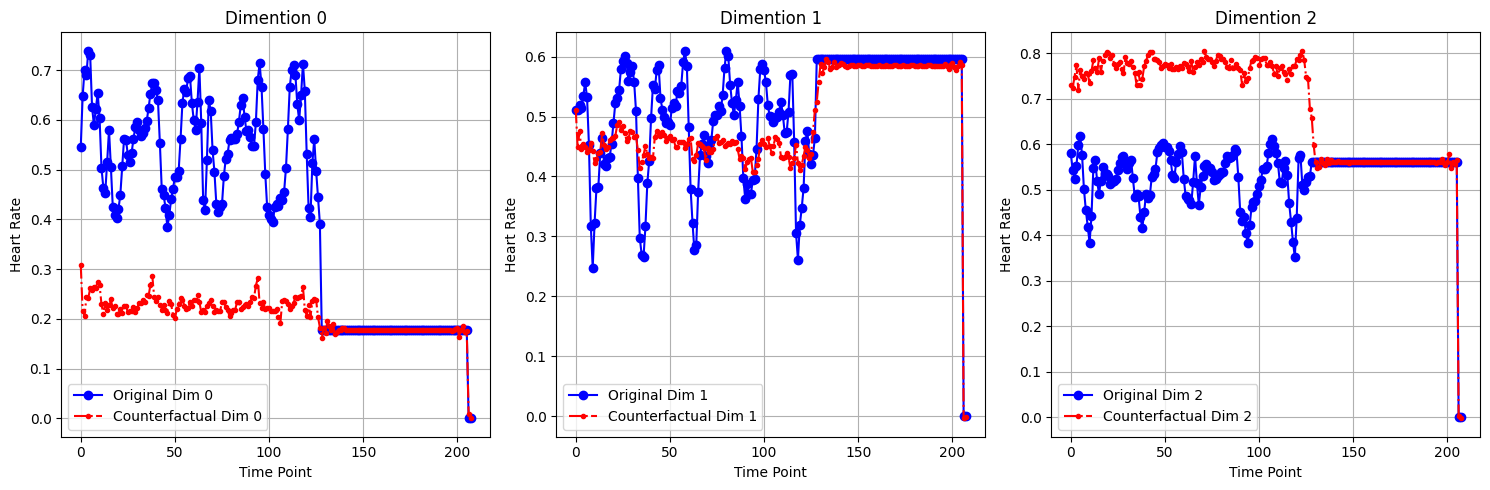

In [64]:
idx = 0
import matplotlib.pyplot as plt

# Example data for two classes for each dimension
heart_rate_data_class1 = X[1,:,1]
heart_rate_data_class2 = [65, 70, 72, 75, 78, 80, 82, 85, 87, 88, 90, 92]
temperature_data_class1 = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
temperature_data_class2 = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pressure_data_class1 = [1010, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020]
pressure_data_class2 = [1009, 1011, 1012, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plotting each dimension for class 1
axs[0].plot(range(len(X_neg[1,:,1])), X_neg[idx,:,0], marker='o', linestyle='-', color='blue', label='Original Dim 0')
axs[0].set_title('Dimention 0')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Heart Rate')
axs[0].grid(True)

axs[1].plot(range(len( X_neg[1,:,1])), X_neg[idx,:,1], marker='o', linestyle='-', color='blue', label='Original Dim 1')
axs[1].set_title('Dimention 1')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Heart Rate')
axs[1].grid(True)

axs[2].plot(range(len( X_neg[1,:,1])), X_neg[idx,:,2], marker='o', linestyle='-', color='blue', label='Original Dim 2')
axs[2].set_title('Dimention 2')
axs[2].set_xlabel('Time Point')
axs[2].set_ylabel('Heart Rate')
axs[2].grid(True)

# Plotting each dimension for class 2
axs[0].plot(range(len( cf_embeddings[1,:,1])), cf_embeddings[idx,:,0], marker='.', linestyle='-.', color='red', label='Counterfactual Dim 0')
axs[1].plot(range(len( cf_embeddings[1,:,1])), cf_embeddings[idx,:,1], marker='.', linestyle='-.', color='red', label='Counterfactual Dim 1')
axs[2].plot(range(len( cf_embeddings[1,:,1])), cf_embeddings[idx,:,2], marker='.', linestyle='-.', color='red', label='Counterfactual Dim 2')

# Add legends
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [56]:
X[y_classes == 1][0].shape


(208, 3)

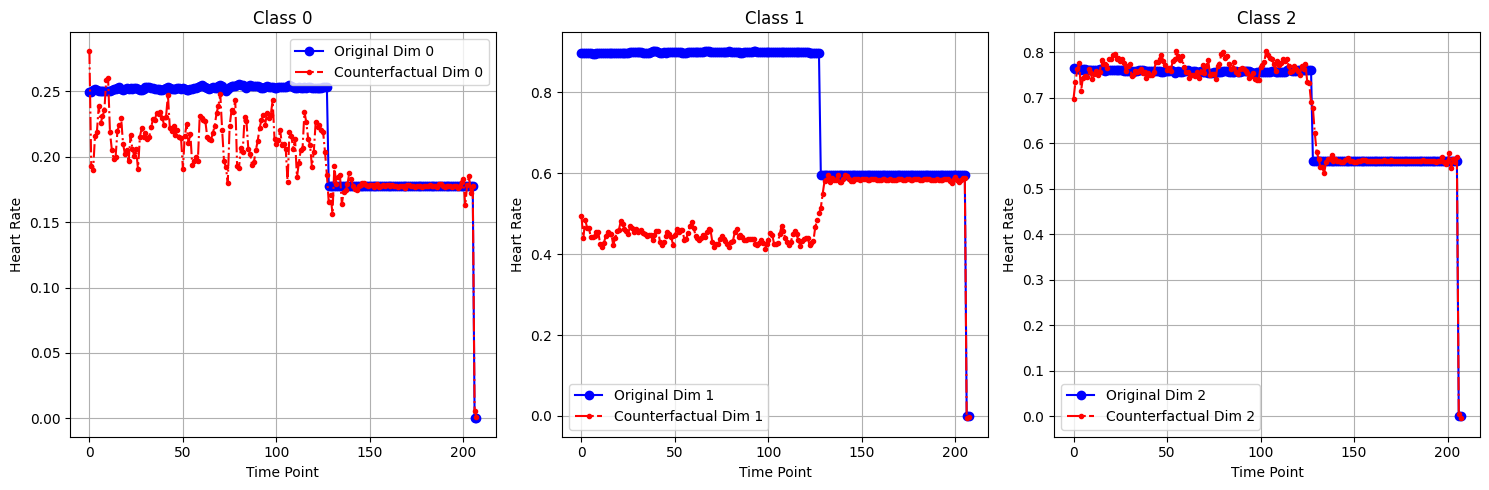

In [58]:
idx = 1
import matplotlib.pyplot as plt

# Example data for two classes for each dimension
heart_rate_data_class1 = X[1,:,1]
heart_rate_data_class2 = [65, 70, 72, 75, 78, 80, 82, 85, 87, 88, 90, 92]
temperature_data_class1 = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
temperature_data_class2 = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pressure_data_class1 = [1010, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020]
pressure_data_class2 = [1009, 1011, 1012, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plotting each dimension for class 1
axs[0].plot(range(len(X[y_classes == 1][1,:,1])), X[y_classes == 1][idx,:,0], marker='o', linestyle='-', color='blue', label='Original Dim 0')
axs[0].set_title('Class 0')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Heart Rate')
axs[0].grid(True)

axs[1].plot(range(len( X[y_classes == 1][1,:,1])), X[y_classes == 1][idx,:,1], marker='o', linestyle='-', color='blue', label='Original Dim 1')
axs[1].set_title('Class 1')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Heart Rate')
axs[1].grid(True)

axs[2].plot(range(len( X[y_classes == 1][1,:,1])), X[y_classes == 1][idx,:,2], marker='o', linestyle='-', color='blue', label='Original Dim 2')
axs[2].set_title('Class 2')
axs[2].set_xlabel('Time Point')
axs[2].set_ylabel('Heart Rate')
axs[2].grid(True)

# Plotting each dimension for class 2
axs[0].plot(range(len( cf_embeddings[1,:,1])), cf_embeddings[idx,:,0], marker='.', linestyle='-.', color='red', label='Counterfactual Dim 0')
axs[1].plot(range(len( cf_embeddings[1,:,1])), cf_embeddings[idx,:,1], marker='.', linestyle='-.', color='red', label='Counterfactual Dim 1')
axs[2].plot(range(len( cf_embeddings[1,:,1])), cf_embeddings[idx,:,2], marker='.', linestyle='-.', color='red', label='Counterfactual Dim 2')

# Add legends
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
#Validity

cf_pred = cnnClassifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
cf_pred_labels = cf_pred
for idx in range(cf_pred_labels.shape[0]):
  if cf_pred_labels[idx] > 0.5:
    cf_pred_labels[idx] = 1
  else:
    cf_pred_labels[idx] = 0


print(f'Transformation_finished with validity_score = {validity_score(y_neg,cf_pred_labels)}')

In [ ]:
#Calculating ΜΑΕ
from tensorflow.keras.losses import MeanSquaredError
total = 0
probability = 0.5
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = cnnClassifier.predict(counterfactual)[:, 1]
    dist = (prediction - probability)
    total +=dist
mean_mae = total /cf_embeddings.shape[0]


In [ ]:
print(f"The Mean MΑE of the data is: {mean_mae} ")

In [ ]:
#Calculating proximity
from tensorflow.keras.losses import MeanSquaredError
total = 0
probability = 0.5
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = cnnClassifier.predict(counterfactual)[:, 1]
    dist = abs(prediction - probability)
    total +=dist
abs_mean_mae = total /cf_embeddings.shape[0]


In [ ]:
print(f"The Absolute Mean MAE of the data is: {abs_mean_mae} ")

In [ ]:
#Proximity
def euclidean_distance(X, cf_samples):
    paired_distances = np.linalg.norm(X - cf_samples, axis=1)
    return np.mean(paired_distances)
euclidean_distance(X_neg, cf_embeddings)

In [ ]:
def remove_paddings(cf_samples, padding_size):
    if padding_size != 0:
        # use np.squeeze() to cut the last time-series dimension, for evaluation
        cf_samples = np.squeeze(cf_samples[:, :-padding_size, :])
    else:
        cf_samples = np.squeeze(cf_samples)
    return cf_samples

In [ ]:
# Remove paddings because KDE does not work with paddings.

X_unpadded = remove_paddings(X, padding_size)
cf_embeddings_unpadded = remove_paddings(cf_embeddings, padding_size)

In [ ]:
import tensorflow as tf
import numpy as np

def train_gaussian_kde(data, use_scotts_rule=False, use_silvermans_rule=None, manual_bandwidth=0.5):
    """
    Train a Gaussian KDE on the provided data.

    :param data: Multivariate data points used for KDE, shape (samples, timesteps).
    :param use_scotts_rule: Use Scott's Rule for bandwidth estimation.
    :param use_silvermans_rule: Use Silverman's Rule for bandwidth estimation.
    :param manual_bandwidth: Manually specified bandwidth (float).
    :return: A function that represents the trained KDE.
    """
    n, d = map(tf.cast, [tf.shape(data)[0], tf.shape(data)[1]], [tf.float32, tf.float32])

    # Calculate bandwidth
    if use_scotts_rule:
        sigma = tf.math.reduce_std(data)
        bandwidth = n ** (-1.0 / (d + 4)) * sigma
    elif use_silvermans_rule:
        sigma = tf.math.reduce_std(data)
        bandwidth = (4 * sigma ** 5 / (3 * n)) ** (1/5)
    else:
        if manual_bandwidth is None:
            raise ValueError("Manual bandwidth must be provided if not using Scott's or Silverman's Rule.")
        bandwidth = manual_bandwidth

    bandwidth = tf.cast(bandwidth, tf.float32)

    def kde_fn(x_points):
        """
        Evaluate the KDE on new data points.

        :param x_points: New data points to evaluate, shape (samples, timesteps).
        :return: Density estimates for each point.
        """
        # Reshape and expand dimensions for broadcasting
        x_points_exp = tf.expand_dims(x_points, 1)
        data_exp = tf.expand_dims(data, 0)

        # Calculate the kernel
        diff = x_points_exp - data_exp
        norm = tf.reduce_sum(diff ** 2, axis=2)
        kernel_val = tf.exp(-norm / (2.0 * bandwidth ** 2))

        # Density calculation
        density = tf.reduce_mean(kernel_val, axis=1) / (bandwidth * tf.sqrt(2.0 * np.pi * d))
        return density

    return kde_fn

def gaussian_kde_logpdf( kde_fn, x_points):
  density = kde_fn(x_points)
  return tf.math.log(density)


In [ ]:
from scipy.stats import gaussian_kde
diffrences_from_abnormal = []
diffrences_from_normal = []
for dimention in range(cf_embeddings.shape[2]):


  abnormal_data = tf.cast(X_unpadded[y_classes == 1][:,:,dimention],tf.float32)
  normal_data = tf.cast(X_unpadded[y_classes == 0][:,:,dimention],tf.float32)
  counterf_data = tf.cast(cf_embeddings_unpadded[:,:,dimention],tf.float32)

  #get the kernel for every dimention of the trained
  kernel = train_gaussian_kde(abnormal_data)

  #get all the log likelihoods
  log_likelihood_abnormal = np.mean(gaussian_kde_logpdf(kernel,abnormal_data))
  log_likelihood_normal = np.mean(gaussian_kde_logpdf(kernel,normal_data))
  log_likelihood_counterfactual = np.mean(gaussian_kde_logpdf(kernel,counterf_data))

  #get the diffrences from the counterfactuals
  diff_from_abnormal = abs(log_likelihood_counterfactual-log_likelihood_abnormal)
  diffrences_from_abnormal.append(diff_from_abnormal)

  diff_from_normal = abs(log_likelihood_counterfactual-log_likelihood_normal)
  diffrences_from_normal.append(diff_from_normal)

In [ ]:
print(diffrences_from_normal)

In [ ]:
print(diffrences_from_abnormal)

In [ ]:
print(np.mean(diffrences_from_normal))

In [ ]:
print(np.mean(diffrences_from_abnormal))